In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
os.environ["LATEXIFY"] = ""
os.environ["FIG_DIR"] = "figures/"

import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt

from pyDOE2.doe_lhs import lhs
import regdata as rd

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import gpax.kernels as gpk
import gpax.likelihoods as gpl
import gpax.means as gpm
from gpax.models import ExactGPRegression, SparseGPRegression, LatentGPHeinonen
from gpax.utils import DataScaler
from gpax.core import set_positive_bijector


from probml_utils import savefig, latexify

# enable x64 mode
jax.config.update("jax_enable_x64", True)

# set the default positive bijector
set_positive_bijector(tfb.Exp())

/home/anonymous/miniconda3/envs/jax_gpu/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: LOCAL is an invalid version and will not be supported in a future release
  warnings.warn(
/home/anonymous/miniconda3/envs/jax_gpu/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: pre-0.1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
X_, y_, _ = rd.MotorcycleHelmet().get_data()
X_, y_ = jnp.asarray(X_), jnp.asarray(y_)
X_test = jnp.linspace(-1, 2, 200)[:, None]

scaler = DataScaler(X_, y_)
X, y = scaler.transform(X_, y_)

(94, 1)
Z-debug (94, 1) (94, 1) (94, 1) (94, 1)
log_likelihood=Traced<ShapedArray(float64[])>with<JVPTrace(level=3/1)> with
  primal = Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/1)>
  tangent = Traced<ShapedArray(float64[])>with<JaxprTrace(level=2/1)> with
    pval = (ShapedArray(float64[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f4dc8559950>, in_tracers=(Traced<ShapedArray(float64[]):JaxprTrace(level=2/1)>, Traced<ShapedArray(float64[]):JaxprTrace(level=2/1)>), out_tracer_refs=[<weakref at 0x7f4dc84bf2c0; to 'JaxprTracer' at 0x7f4dc84bf180>], out_avals=[ShapedArray(float64[])], primitive=xla_call, params={'device': None, 'backend': None, 'name': '<lambda>', 'donated_invars': (False, False), 'inline': True, 'keep_unused': False, 'call_jaxpr': { lambda ; a:f64[] b:f64[]. let c:f64[] = sub a b in (c,) }}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7f4dc8568bf0>, name_stack=NameStack(stack=(Transform

<AxesSubplot: >

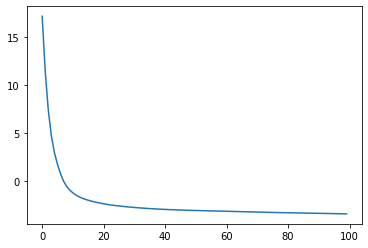

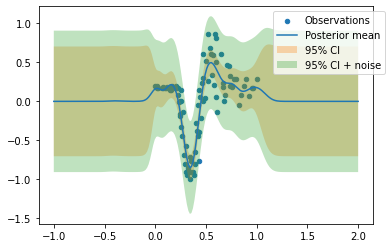

In [3]:
# X_inducing = X[::10]
X_inducing = X
print(X_inducing.shape)
latent_kernel = gpk.Scale(X_inducing, gpk.RBF(X_inducing, lengthscale=0.2), variance=1.0).trainable(False)
latent_model = LatentGPHeinonen(X_inducing, latent_kernel, vmap=True)
base_kernel = gpk.Gibbs(X_inducing, latent_model)
kernel = gpk.Scale(X, base_kernel, variance=0.3**2)

model = ExactGPRegression(kernel, gpl.Gaussian(scale=0.05), gpm.Average(), X_inducing)
model.kernel.base_kernel.latent_model.reverse_init(jnp.array(0.05))

key = jax.random.PRNGKey(0)


def customize_fn(model):
    model.kernel.base_kernel.latent_model.reverse_init(jnp.array(0.05))
    model.likelihood.scale.set_value(jnp.array(0.05))

# customize_fn(model)
# print(model.log_probability(X, y)*X.size)

res = model.fit(key, X, y, epochs=100, lr=0.1, customize_fn=customize_fn)

plt.plot(res["loss_history"])

plt.figure()
model.plot(X, y, X_test)

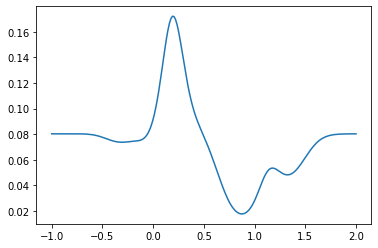

In [4]:
model.eval()
model.set_raw_parameters(res["raw_params"])
ell = model.kernel.base_kernel.latent_model(X_inducing)(X_test)

plt.plot(X_test, ell);

## Motivation for Heteroscedasticity

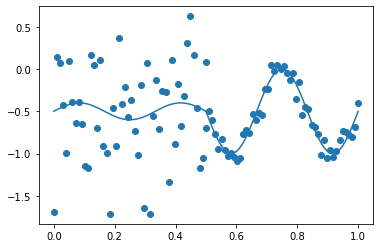

In [5]:
x1 = jnp.linspace(0, 0.5, 50)[:, None]
y1 = 0.1*jnp.sin(6 * jnp.pi * x1) - 0.5
y1_noisy = y1 + 0.6 * jax.random.normal(jax.random.PRNGKey(0), x1.shape)
x2 = jnp.linspace(0.5, 1, 50)[:, None]
y2 = 0.5*jnp.sin(6 * jnp.pi * x2) - 0.5
y2_noisy = y2 + 0.1 * jax.random.normal(jax.random.PRNGKey(0), x2.shape)
x_test = jnp.linspace(-0.5, 1.1, 150)[:, None]

x = jnp.concatenate([x1, x2])
y = jnp.concatenate([y1, y2]).ravel()
y_noisy = jnp.concatenate([y1_noisy, y2_noisy]).ravel()

plt.plot(x, y, label="$f$");
plt.scatter(x, y_noisy, label="$y$");

In [6]:
homo_model = ExactGPRegression(gpk.Scale(x, gpk.RBF(x)), gpl.Gaussian(), gpm.Average())
def customize_fn(model):
    model.kernel.base_kernel.lengthscale.set_value([0.01])

key = jax.random.PRNGKey(0)
homo_res = homo_model.fit(key, x, y_noisy, epochs=100, lr=0.1, customize_fn=customize_fn)

# plt.plot(homo_res["loss_history"])
# plt.plot(jax.nn.softplus(homo_res["raw_params_history"]["kernel"]["base_kernel"]["lengthscale"]))

# latexify(fig_width=3, fig_height=1, font_size=7)
# savefig("demo_homo")

log_likelihood=Traced<ShapedArray(float64[])>with<JVPTrace(level=3/1)> with
  primal = Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/1)>
  tangent = Traced<ShapedArray(float64[])>with<JaxprTrace(level=2/1)> with
    pval = (ShapedArray(float64[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f4dc8159ec0>, in_tracers=(Traced<ShapedArray(float64[]):JaxprTrace(level=2/1)>, Traced<ShapedArray(float64[]):JaxprTrace(level=2/1)>), out_tracer_refs=[<weakref at 0x7f4dc8035810; to 'JaxprTracer' at 0x7f4dc8035860>], out_avals=[ShapedArray(float64[])], primitive=xla_call, params={'device': None, 'backend': None, 'name': '<lambda>', 'donated_invars': (False, False), 'inline': True, 'keep_unused': False, 'call_jaxpr': { lambda ; a:f64[] b:f64[]. let c:f64[] = sub a b in (c,) }}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7f4dc8077e30>, name_stack=NameStack(stack=(Transform(name='jvp'), Scope(name='MultivariateNormalFull

In [17]:
print(x.shape, y_noisy.shape)
x_inducing = x[::10]
print(x_inducing.shape)
latent_kernel = gpk.Scale(x_inducing, gpk.RBF(x_inducing, lengthscale=0.2), variance=1.0).trainable(False)
latent_model = LatentGPHeinonen(x_inducing, latent_kernel, vmap=False)
likelihood = gpl.Heteroscedastic(latent_model)
hetero_model = SparseGPRegression(gpk.Scale(x, gpk.RBF(x)), likelihood, gpm.Average(), x_inducing)
def customize_fn(model):
    model.kernel.base_kernel.lengthscale.set_value([0.01])
    pass

key = jax.random.PRNGKey(9)

# print(hetero_model.log_probability(x, y_noisy))

hetero_res = hetero_model.fit(key, x, y_noisy, epochs=1000, lr=0.01, customize_fn=customize_fn)

# plt.plot(hetero_res["loss_history"])
# plt.plot(jax.nn.softplus(homo_res["raw_params_history"]["kernel"]["base_kernel"]["lengthscale"]))

pred_mean, pred_var = homo_model.predict(x, y, x_test)
pred_mean, pred_var_noiseless = homo_model.predict(x, y, x_test, include_noise=False)
pred_std = jnp.sqrt(pred_var)
pred_std_noiseless = jnp.sqrt(pred_var_noiseless)

latexify(fig_width=3, fig_height=2.2, font_size=7)
fig, ax = plt.subplots(2, 1, sharey=True, sharex=True)

ax[0].scatter(x, y_noisy, s=1)
ax[0].plot(x_test, pred_mean, color='r')
ax[0].plot(x, y, color='k', linestyle='--');
ax[0].fill_between(x_test.ravel(), pred_mean.ravel() - 2*pred_std.ravel(), pred_mean.ravel() + 2*pred_std.ravel(), alpha=0.2)
ax[0].fill_between(x_test.ravel(), pred_mean.ravel() - 2*pred_std_noiseless.ravel(), pred_mean.ravel() + 2*pred_std_noiseless.ravel(), alpha=0.2);
# plt.legend(loc='upper left');

hetero_model.set_raw_parameters(hetero_res["raw_params"])
# hetero_model.plot(x, y_noisy, x_test)
# plt.plot(x, y, label="$f$");

pred_mean, pred_var = hetero_model.predict(x, y, x_test)
pred_mean, pred_var_noiseless = hetero_model.predict(x, y, x_test, include_noise=False)
pred_std = jnp.sqrt(pred_var)
pred_std_noiseless = jnp.sqrt(pred_var_noiseless)

ax[1].scatter(x, y_noisy, s=1)
ax[1].plot(x_test, pred_mean, color='r')
ax[1].plot(x, y, color='k', linestyle='--');
ax[1].fill_between(x_test.ravel(), pred_mean.ravel() - 2*pred_std.ravel(), pred_mean.ravel() + 2*pred_std.ravel(), alpha=0.2)
ax[1].fill_between(x_test.ravel(), pred_mean.ravel() - 2*pred_std_noiseless.ravel(), pred_mean.ravel() + 2*pred_std_noiseless.ravel(), alpha=0.2)
ax[1].scatter(hetero_res["raw_params"]["X_inducing"], -2*jnp.ones(hetero_res["raw_params"]["X_inducing"].shape[0]), marker='^', color='k')
# plt.legend(loc='upper left');
ax[0].text(0.05, 0.9, "Homoscedastic GP", transform=ax[0].transAxes)

ax[1].text(0.05, 0.9, "Sparse Heteroscedastic GP", transform=ax[1].transAxes)
ax[1].set_xlabel("$x$")
ax[0].vlines(0.5, *ax[0].get_ylim(), linestyle='--', color='k', label="$x=0.5$", alpha=0.5)
ax[1].vlines(0.5, *ax[1].get_ylim(), linestyle='--', color='k', label="$x=0.5$", alpha=0.5)
ax[0].legend()
ax[1].legend()

savefig("demo_hetero")

(100, 1) (100,)
(10, 1)
saving image to figures/demo_hetero_latexified.pdf
Figure size: [3.  2.2]
